In [4]:
import pandas as pd
import numpy as np
from geopy.distance import distance as geo_dist
import datetime
import time
import matplotlib.pyplot as plt
import scipy.stats as st
import os

from tqdm import tqdm

# DS Lab - Final Assignment: Robust Journey Planning

## Table of contents:
- ### [Preprocessing](#preprocessing)
    - #### [Zürich stops selection.](#zurich_stop_selection)
    - #### [Data cleaining.](#data_cleaning)
    - #### [Creation of connections between stations.](#creation_connection)
- ### [Delay estimation](#delay_estimation)
    - #### [Computation.](#delay_computation)
    - #### [Visualization.](#delay_visualization)
- ### [CSA](#csa)
    - #### [Algorithm](#csa_algorithm)
    - #### [Results](#csa_results)

<a id="preprocessing"></a>
## Preprocessing

<a id="zurich_stop_selection"></a>
### Zürich stops selection

Below, we extract the stations from the metadata file and compute their distance to Zürich HB. 
Each data files are then filtered and only contain station at a distance lower than 10 km to Zürich HB.

In [ ]:
# Extract list of stop from metadata file.
with open("data/BFKOORD_GEO") as file:
    metadata = file.readlines()
    
metadata_cleaned = [line.split("%") for line in metadata]
metadata_cleaned = [[line[0].split(), line[1][1:-1]] for line in  metadata_cleaned]
metadata_cleaned = [[line[0][0], line[0][1], line[0][2], line[0][3], line[1]] for line in metadata_cleaned]

metadata_df = pd.DataFrame(metadata_cleaned, columns=["StationID", "Longitude", "Latitude", "Height", "Remark"])

metadata_df["Longitude"] = pd.to_numeric(metadata_df["Longitude"])
metadata_df["Latitude"] = pd.to_numeric(metadata_df["Latitude"])

In [ ]:
# Retrieve stops near Zurich main station
zurichHB = metadata_df[metadata_df.Remark == "Zürich HB"]

metadata_df["dist"] = metadata_df.apply(lambda x: geo_dist((zurichHB.Latitude.values[0], zurichHB.Longitude.values[0]),
                                                            (x.Latitude, x.Longitude)).km, axis=1)
zurich_stops_df = metadata_df[metadata_df["dist"] < 10]
zurich_stops_df.head()

In [ ]:
# Filter the city in each files.
zurich_stops_lower_name = zurich_stops_df.Remark.str.lower()
for d in os.listdir("data/raw"):
    for f in os.listdir(os.path.join("data/raw", d)):
        print(f, end="\r")
        data_df = pd.read_csv(os.path.join("data/raw", os.path.join(d, f)), sep=";").dropna(subset = ["HALTESTELLEN_NAME"])
        filtered_data = data_df[data_df.HALTESTELLEN_NAME.str.lower().isin(zurich_stops_lower_name)]    
        filtered_data.to_csv(os.path.join("data/filtered", os.path.join(d, f)), sep=";", index=False)

<a id="data_cleaning"></a>
### Data cleaning

Now that we have filtered stops that are too far away, we can preprocess our data:

- We transform every time to its timestamp.
- Compute the lateness of trains.
- Remove all transports that only stop once in the 10km area around Zürich-HB

In [ ]:
frmt1 = "%d.%m.%Y %H:%M:%S"
frmt2 = "%d.%m.%Y %H:%M"


def to_timestamp(x, date_format):
    '''
        Transform a date to its timestamp given a date_format.
        NaN values are mapped to -99999
    '''
    if pd.isnull(x):
        return -99999
    else:
        return time.mktime(datetime.datetime.strptime(x, date_format).timetuple())


def time_diff(x, y):
    '''
        Compute the time difference between two values.
    '''
    if (x == -99999) & (y == -99999):
        return -99999
    elif (x == -99999) | (y == -99999):
        return 0
    else:
        return y - x


def get_day(x):
    if pd.isnull(x):
        return -1
    else:
        return datetime.datetime.strptime(x, "%d.%m.%Y").weekday()

usefull_columns = ['FAHRT_BEZEICHNER', 'HALTESTELLEN_NAME', 'ANKUNFTSZEIT',
    'ABFAHRTSZEIT', 'DURCHFAHRT_TF', 'ZUSATZFAHRT_TF',
    'AN_PROGNOSE', 'BETRIEBSTAG']
    
def preprocess(file):
    '''
        Creates a preprocessed dataframe from the filename.
    '''
    df = pd.read_csv(file, sep=";", usecols=usefull_columns)

    df = df[df['DURCHFAHRT_TF'] != True]
    df = df[df['ZUSATZFAHRT_TF'] != True]
    
    df['ANKUNFTSZEIT'] = df['ANKUNFTSZEIT'].apply(lambda x: to_timestamp(x, frmt2))
    df['ABFAHRTSZEIT'] = df['ABFAHRTSZEIT'].apply(lambda x: to_timestamp(x, frmt2))
    df['AN_PROGNOSE'] = df['AN_PROGNOSE'].apply(lambda x: to_timestamp(x, frmt1))

    df['LATENESS_arrival'] = df[['ANKUNFTSZEIT', 'AN_PROGNOSE']].apply(lambda x: time_diff(*x), axis=1)
    df['DAY'] = df['BETRIEBSTAG'].apply(lambda x: get_day(x))

    df = df.drop(['DURCHFAHRT_TF', 'ZUSATZFAHRT_TF', 'AN_PROGNOSE', 'BETRIEBSTAG'], axis=1)
    
    indexes = df.groupby("FAHRT_BEZEICHNER")["HALTESTELLEN_NAME"].count()    
    df = df[(indexes[df.FAHRT_BEZEICHNER] > 1).values]
    
    return df


files = list()
for d in os.listdir("data/filtered/"):
    for f in os.listdir(os.path.join("data/filtered/", d)):
        files.append('data/filtered/'+d+'/'+f)

data_df = pd.concat((preprocess(f) for f in tqdm(files)))

tr_col_name = {
'FAHRT_BEZEICHNER': 'TRIP_ID',
'HALTESTELLEN_NAME': 'STOP_STATION_NAME',
'ANKUNFTSZEIT': 'ARRIVAL_TIME',
'ABFAHRTSZEIT': 'DEPARTURE_TIME',
'LATENESS_arrival': 'LATENESS_arrival',
'DAY': 'DAY'}

data_df = data_df.rename(columns=tr_col_name)

data_df.to_csv('preprocessed.csv', encoding='utf-8', sep=";", index=False)

  0%|          | 0/230 [00:00<?, ?it/s]/usr/local/lib/python3.5/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
100%|██████████| 230/230 [1:58:09<00:00, 30.83s/it]


In [ ]:
data_df = pd.read_csv("preprocessed.csv")

In [48]:
data_df.head()

,TRIP_ID,STOP_STATION_NAME,ARRIVAL_TIME,DEPARTURE_TIME,LATENESS_arrival,DAY
21,85:11:1507:002,Zürich HB,1.516689e+09,1.516690e+09,-32.0,1
22,85:11:1507:002,Zürich Flughafen,1.516690e+09,1.516690e+09,1.0,1
24,85:11:1509:003,Zürich HB,1.516693e+09,1.516693e+09,115.0,1
25,85:11:1509:003,Zürich Flughafen,1.516694e+09,1.516694e+09,56.0,1
26,85:11:1510:003,Zürich Flughafen,1.516691e+09,1.516692e+09,6.0,1


<a id="creation_connection"></a>
### Creation of connections between stations.

In the cells below, we create dataframes that contains every connections by day of the week.
They are used in the CSA algorithm.

In [34]:
start_mon = time.mktime(datetime.datetime(2018, 1, 8).timetuple())
end_mon = time.mktime(datetime.datetime(2018, 1, 15).timetuple())

In [44]:
week_df = data_df[(data_df.ARRIVAL_TIME > start_mon) & (data_df.ARRIVAL_TIME < end_mon)]

In [59]:
links = []

def handle_group(group):
    if len(group) > 1:
        stops = group[['STOP_STATION_NAME', 'ARRIVAL_TIME', 'DEPARTURE_TIME', 'TRIP_ID']].sort_values('ARRIVAL_TIME').values
        for link in zip(stops[:-1], stops[1:]):
            if link[0][2] < 0:
                link[0][2] = link[0][1]
            if link[0][1] < 0:
                link[0][1] = link[0][2]
            if link[1][2] < 0:
                link[1][2] = link[1][1]
            if link[1][1] < 0:
                link[1][1] = link[1][2]
            if link[0][0] != link[1][0]:
                links.append([link[0][0], link[1][0], link[0][2], link[1][1], link[0][3]])

In [61]:
for d in tqdm(range(7)):
    group = week_df[week_df.DAY == d].groupby("TRIP_ID")    
    links = []
    
    group.apply(lambda g: handle_group(g))
    links_df = pd.DataFrame(links).sort_values(2)
    links_df = links_df.rename(columns={0: "DEP_STATION", 1:"ARR_STATION", 2:"DEP_TS", 3:"ARR_TS", 4:"TRIP_ID"})
    
    links_df.to_csv("links/links_%s.csv" % (d), index=False, header=False)

  0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.5/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
100%|██████████| 7/7 [01:51<00:00, 15.86s/it]


<a id="delay_estimation"></a>
## Delay estimation

<a id="delay_computation"></a>
### Computation

In [64]:
data_df = data_df[data_df["LATENESS_arrival"] != -99999]

By the Dvoretzky-Kiefer-Wolfowitz inequality, we know that the ecdf (empirical cumulative distribution function) satisfies the following inequality : 

$$\mathbb{Pr}( \sup_{x \in \mathbb{R}} (F_n(x) - F(x)) > \epsilon) \leq e^{-2n\epsilon^2} \quad \quad \text{for} \quad \epsilon \geq \sqrt{\frac{1}{2n} \ln(2)}$$

$$ \text{Where } n \text{ is the number of samples, } F_n(x) \text{ is our ecdf and } \\ F(x) \text{ is the underlying cumulative distribution of the lateness (which also represent the risk of being less than M minutes late).}$$

With this equation, we can compute 95% confidence interval for F and thus integrate in our risk estimation : 
- The variance inside a group with the ecdf
- The number of samples inside a group with the confidence bound

$$\text{Finally, to compute the confidence bound, we will set } \epsilon = \sqrt{\frac{1}{2n} log(2/0.05)}$$

This leads to our upperbound U(M) for the risk of being late by M minutes: 
$$ U(M) = 1 - max(F_n(M) - \epsilon, 0) $$ 

In [65]:
def compute_risk_with_confidence_bound(data):
    '''
    Compute the fraction of transport that are more than M minutes late. 
    M is each values that the transport can be late.
    
    Use this table as a risk that the transport is more than M minute late.
    '''
    sorted_data = np.sort(data)
    values = np.unique(sorted_data)
    data_len = len(sorted_data)
    
    
    confidence_bound = 0.05
    epsilon = np.sqrt(1 / (2 * data_len) * np.log(2 / confidence_bound))
    
    percentile_dict = {}
    
    index = 0
    for v in values:
        try:
            index = next(i for i in range(index, data_len) if sorted_data[i] > v)
            percentile_dict[v] = 1 - max(index / data_len - epsilon, 0)
        except StopIteration:
            percentile_dict[v] = 0
            
    return percentile_dict

In [66]:
groupby_col = ["DAY", "TRIP_ID"]

grouped_df = data_df.groupby(groupby_col)
grouped_delay_df = grouped_df.apply(lambda group: group["LATENESS_arrival"])
grouped_ecdf_df = grouped_df.apply(lambda group: pd.Series(compute_risk_with_confidence_bound(group["LATENESS_arrival"].values)))

In [68]:
metric_df = grouped_delay_df.groupby(level=[0,1]).agg(["count", "var"])

In [70]:
metric_df.head()

count            var
DAY TRIP_ID                              
0   85:11:13710:001      8   67090.267857
    85:11:13711:001      6   32371.766667
    85:11:13712:001     16  115168.029167
    85:11:13713:001     16    1474.929167
    85:11:13714:001     16   46785.050000

In [ ]:
grouped_ecdf_df.to_pickle("risk_df.pkl")

In [7]:
grouped_ecdf_df = pd.read_pickle("risk_df.pkl")

<a id="delay_visualization"></a>
### Visualization

In [213]:
def plot_risk_of_lateness(ecdf_data, title=""):
    plt.figure(figsize=(20, 4))
    plt.plot(ecdf_data.keys(), ecdf_data.values)
    plt.xlabel("seconds")
    plt.ylabel("risk of being late")
    plt.title(title)
    plt.show()
    
def plot_risk_of_lateness_per_day(transport, trip_id, interval=60):
    plt.figure(figsize=(20,4))
    
    for sec in range(0, interval*5, interval):
        plt.bar(np.asarray(range(7)) -0.3 + 0.15*int(sec/interval), [transport.loc[:,:sec].loc[i].iloc[-1] for i in range(7)], width=0.1)

    plt.xticks(range(7), ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
    plt.title("Risk of being late for TRIP_ID = %s per days" % trip_id)
    plt.ylabel("Risk of being more than m minutes late")
    plt.legend(["%s sec" % i for i in range(0, interval * 5, interval)])

    plt.show()

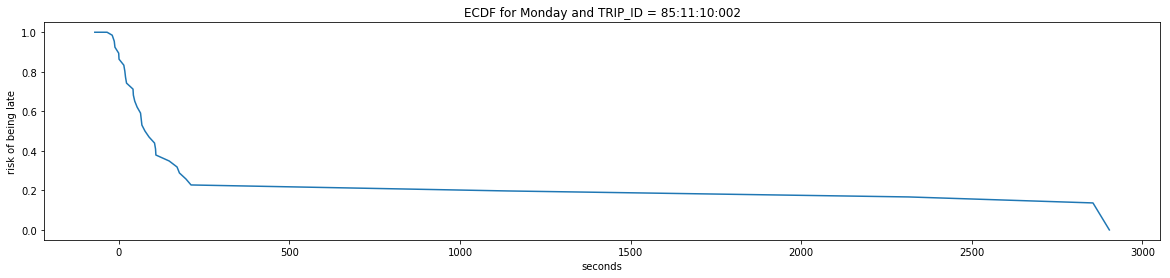

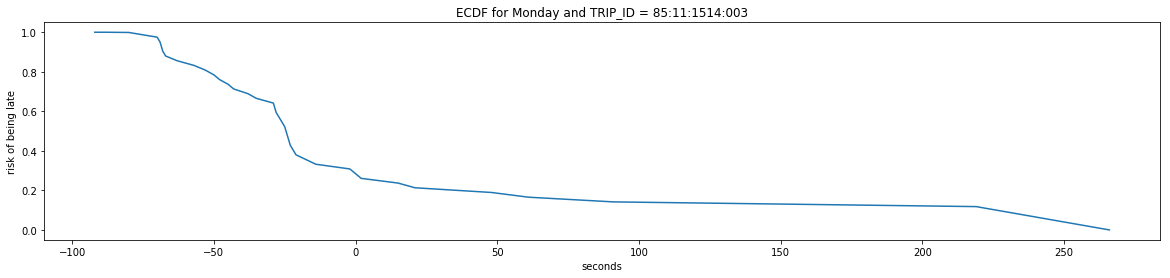

In [214]:
ecdf1 = grouped_ecdf_df.loc[0, "85:11:10:002"]
ecdf2 = grouped_ecdf_df.loc[0, "85:11:1514:003"]

plot_risk_of_lateness(ecdf1, title="ECDF for Monday and TRIP_ID = 85:11:10:002")
plot_risk_of_lateness(ecdf2, title="ECDF for Monday and TRIP_ID = 85:11:1514:003")

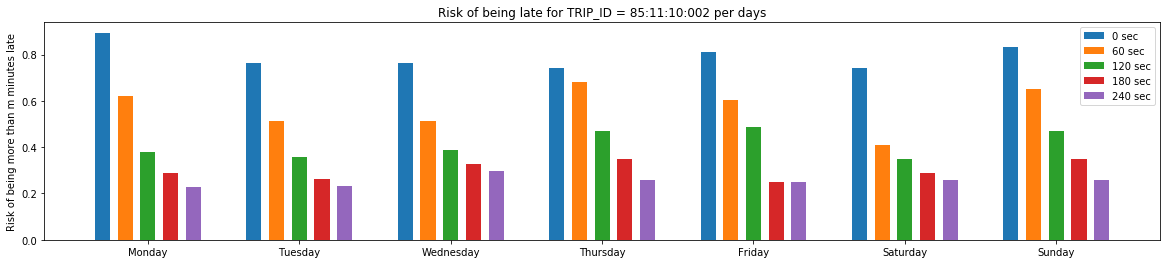

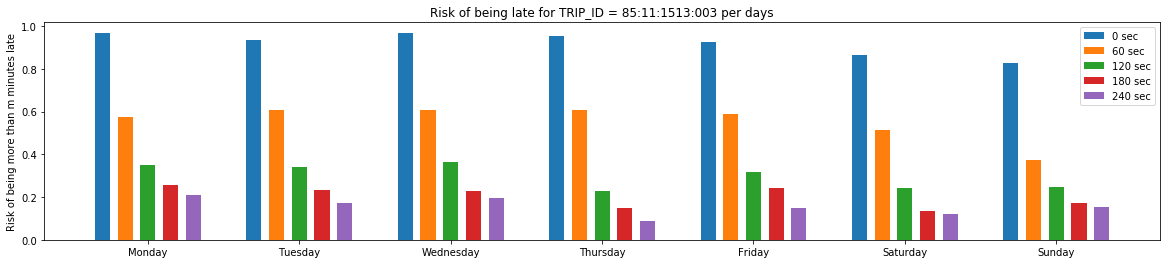

In [215]:
plot_risk_of_lateness_per_day(grouped_ecdf_df.loc[:, "85:11:10:002"], "85:11:10:002")
plot_risk_of_lateness_per_day(grouped_ecdf_df.loc[:, "85:11:1513:003"], "85:11:1513:003")

<a id="csa"></a>
## CSA

<a id="csa_algorithm"></a>
### Algorithm

In the following cells, we implement the CSA algorithm.
The algorithm is defined in separate .py files.

The files ```run_csa_sbb.py ``` and ```csa.py``` contains the algorithm.
First, it adds the walking connections between two stops at distance smaller than 500 meters.
Then we add all other transport connections. A connection contains the following informations : 
- Departure station
- Arrival station
- Departure time
- Arrival time
- TRIP_ID
These connections are stored by day on a pickle file named ``` connections.pickle ```.

The core of the algorithm is quite straight forward : 

Data structures:
    - A dictionary with each stations that we can reach. Each station contains: 
        - Station name
        - Timestamp when the station can be reached
        - Certainty to reach the station
        - The duration of  the trip 

Procedure:
    1. For each connections sorted by departure timestamp.
        2. See if it allows us to reach a stations faster or with better certainty than what we already can. 
           I.e, we only add a connection if there does not exist a faster way with at least the certainty of 
           this connection. 
           (add_connection from file csa.py for further details)

In [1]:
from csa import connections_sbb
from run_csa_sbb import run, all_stations

csa loading...
run_csa_sbb loading...


In [2]:
departure_timestamp = 1515396840

csa_sbb = run(
    departure_station='Zürich HB',
    arrival_station='Zürich, Zoo',
    departure_timestamp = departure_timestamp,
    min_certainty = 0.05,
    speed = 4,
    top_n = 5
)

<a id="csa_results"></a>
### Results

This cell displays the output of algorithm. It outputs at most the five best paths that satisfy the entered criteria.


You can see the algorithm in action on our website : http://www.robust-planner.com/.

Alternatively, you can run the application locally on a docker with the following command : 
```shell
docker run -idt -p 80:5000 --name labInData gregunz/robustplanner

```
The docker contains every precomputed static files.

Pro:
- The statistical part does not assume anything on the underlying distribution. The delay can have any distribution and our method will work with enough samples.
- CSA returns the fastest path for several certainty level on a single run.


Shortcoming :

- Our way of computing the risk is a bit too conservative. Some groups may be too small, we could try to group them into larger group.

In [5]:
np.random.seed(3)

for s in np.random.choice(all_stations, size = 5):
    print()
    print('{} -> {}'.format(csa_sbb.dep_station, s))
    print()
    for i, p in enumerate(csa_sbb.get_paths(s)):
        duration = int(np.sum([e['duration'] for e in p.edges()]) / 60 * 100) / 100
        print("[path #{}] in {} minutes with {} certainty".format(i+1, duration, int(p.last()['cum_certainty'] * 100) / 100))
        print()
        lines = [['FROM', 'TO', 'DURATION', 'CERTAINTY', 'TRIP_ID']]
        for e in p.edges():
            line = [e['from'], e['to'], int(e['duration'] / 60 * 100) / 100 , int(e['certainty'] * 100) / 100, e['trip_id']]
            line = [str(e) for e in line]
            lines.append(line)
        col_widths = [max([len(word) for word in row]) + 2 for row in pd.DataFrame(lines).T.values ]  # padding
        for row in lines:
            print(''.join(word.ljust(col_widths[i]) for i, word in enumerate(row)))
        print()


Zürich HB -> Zürich, Regensbergbrücke

[path #1] in 17.0 minutes with 0.69 certainty

FROM                      TO                        DURATION  CERTAINTY  TRIP_ID                
Zürich HB                 Zürich Hardbrücke         5.0       1.0        85:11:18926:001        
Zürich Hardbrücke         Zürich Oerlikon           5.0       1.0        85:11:18926:001        
Zürich Oerlikon           Zürich, Sternen Oerlikon  3.4       1.0        walking                
Zürich, Sternen Oerlikon  Zürich, Regensbergbrücke  3.6       0.69       85:849:252097-02062-1  

[path #2] in 17.08 minutes with 1.0 certainty

FROM               TO                        DURATION  CERTAINTY  TRIP_ID          
Zürich HB          Zürich Hardbrücke         5.0       1.0        85:11:18926:001  
Zürich Hardbrücke  Zürich Oerlikon           5.0       1.0        85:11:18926:001  
Zürich Oerlikon    Zürich, Regensbergbrücke  7.08      1.0        walking          


Zürich HB -> Rüschlikon, Park im Grüene

[